# Modelling, Simulation and Optimization Project
## Kenechukwu Otito Ajufo
### School of Computing
### MSc Data Analytics
### National College of Ireland 
### Student ID: x19190174



<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#HS2-Train-Line-Simulation-and-Optimization" data-toc-modified-id="HS2-Train-Line-Simulation-and-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project Overview</a></span></li>
    <li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></span></li>
    <li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span></li>
    <li><span><a href="#Utilities" data-toc-modified-id="Utilities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Time Function</a></span></li>
    <li><span><a href="#Define-Entities-and-Process" data-toc-modified-id="Define-Entities-and-Process-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulation Entities</a></span></li>
    <ul>
        <li><span><a href="#Train" data-toc-modified-id="Train-1"><span class="toc-item-num"></span>Train</a></span></li>
        <li><span><a href="#Stations" data-toc-modified-id="Stations-3"><span class="toc-item-num"></span>Stations</a></span></li>
        <li><span><a href="#Signalling-blocks" data-toc-modified-id="Signalling-blocks-4"><span class="toc-item-num"></span>Signalling blocks</a></span></li>
    </ul>
    <li><span><a href="#System-Verification" data-toc-modified-id="System-Verification-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Main Function</a></span></li>
    <li><span><a href="#Optimization" data-toc-modified-id="Optimization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Optimization</a></span></li>
    <ul>
        <li><span><a href="#Exhaustive-search-(Brute-force-approach)" data-toc-modified-id="Exhaustive-search-(Brute-force-approach)"><span class="toc-item-num"></span>Grid Search</a></span></li> 
        </ul>
    <li><span><a href="#References" data-toc-modified-id="References"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li>
 </ul></div>

## Project Overview

This project is aimed at modelling, simulating and optimizing a high speed line in the London Underground.

## Import Libraries  

In [ ]:
! pip install simpy

In [ ]:
import math 
import pandas as pd
import numpy as np
from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
import simpy.events as evt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Train running and track data

## Data Preparation

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
data.head(1)

,Line,From,To,Travel_Time,Blocks
0,HS2,London Old Oak Commons,Birmingham Interchange,1684,14


#### Simulation Results Dataframe

generateSimulation function generates a dataframe which collects the data for the simulation. The function accepts argument **n**, this is the number of trains for the simulation.

In [ ]:
def generateSimulation(n):
    
    simulationData = pd.DataFrame({'departure':[None]*n, 'destination':[None]*n,'Train':[None]*n,})
    
    return simulationData

In [ ]:
simulation = generateSimulation(10)
simulation

,departure,destination,Train
0,None,None,None
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None
5,None,None,None
6,None,None,None
7,None,None,None
8,None,None,None
9,None,None,None


## Time Function

These two functions to return the appropriate  time format

In [ ]:
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
        
def now():
    return daytime(env.now)

## Simulation Entities

## Train

The **Train** class is created to hold information about the process of train and its processes. The constructor method **(__init__)** is where the the variables for the instance are declared. 

There is an assumption that the trains travel at the same speed during particular stretches of the journey. This keeps the travel times equal, and enables the effect of the signalling blocks to be easily tested. 

The train process is defined in the **process** method. First the train drives from the **depot** to the first station. **This is assumed to take 15 seconds.** The current location is set as the variable **here** and the departure time is recorded in the simulation results table. The track is made up of two stations **London Old Oak Commons and Birmingham interchange**. 

Each destination is derived from the dataframe. The train would wait to depart by requesting for the signalling block. If the signalling block is empty, the train proceeds to enter. If not, the train waits till the signalling block is empty before it can proceed.

The simulation model is verified by inducing a temporary breakdown due to electrical malfunction of the 9am train from London to Birmingham.

In order to reflect operational conditions and introduce variability of travelling times a log-normal distribution is used.


In [ ]:
class Train(object):
  
  def __init__(self, i, j, n, route, trackBlocks):
    self.hour = j
    self.n = n
    self.train_num = i +(self.hour * self.n)
    self.name = '[Train '+f"{i:2d}"+']'
    self.route = route
    self.p   = 0
    self.trackBlocks = trackBlocks
    simulationData.at[self.train_num, 'Train'] = self.name
    max_speed=86.1
    acceleration=0.76
    deceleration=0.38
    brake_distance=(max_speed**2)/(deceleration*2)

  def process(self):
    #check for 9am Train from London to Birmingham
    if env.now >= 32400 and env.now <= 32431:
      timeDelay = 1
    else: timeDelay = 0
      
    #train drives from depot to starting location
    print(f"{now():s} {self.name:s} drives from train depot to starting station")
    yield env.timeout(15)
    
    here = self.route[0]
    simulationData.at[self.train_num, 'departure'] = env.now
     
    for dest in self.route[1:]:
            
            #get data from dataset
            source = data[data['From'] == here]

            #Log-Normal distribution generator
            lognormalDelay = np.random.lognormal(mean = 3.378, sigma = 0.751, size = None)

            drivetime=source.iloc[0].at['Travel_Time'] #+lognormalDelay
            blockNum = source.iloc[0].at['Blocks']
            blockDrive = drivetime/blockNum
            
            #train departs
            print(f"{now():s} {self.name:s} Waiting to depart {here:s} for {dest:s}")
            
            for sig in range(len(self.trackBlocks[here])):
              
              #request signalling block
              print(f"{now():s} {self.name:s} requests block {sig} for journey to {dest:s}")
              
              with self.trackBlocks[here][sig].request() as req:
                yield req
                #Train enters block and signal turns to red
                print(f"{now():s} {self.name:s} enters block {sig} for journey to {dest:s}")
               
               #train driving
                yield env.timeout(blockDrive)
                #30 minutes delay for 9am Train
                if timeDelay == 1:
                  print(f"{now():s} {self.name:s} Sorry! There is a 30 minutes delay due to a temporary breakdown of the 9am Train. The delay is due to electrical malfunction")
                  yield env.timeout(1800)
                  timeDelay = 0
              
               #train arrives station
                if sig == len(self.trackBlocks[here])-1:
                  
                  print(f"{now():s} {self.name:s} arrives {dest:s}")
                       
                  here = dest
                        
                  #final station
                  if here == self.route[-1]:
                          print(f"{now():s} {self.name:s} Train has reached final destination")
                            
                          #record simulation data
                          simulationData.at[self.train_num, 'destination'] = env.now


## Station

In [ ]:
class Stations(object):
    def __init__(self):
        pass
        
    def get_stations():
        
        stations=data['From'].to_list()
        stations+=[data['To'].to_list()[-1]]
        
        return stations

## Signalling Blocks

The **sBlocks** class is created. It handles creation of the signalling blocks for the journey. The **generate** method takes the argument **station** and creates the number of signalling blocks to the next station. It returns this number as **signal_blocks**

In [ ]:
class sBlocks(object):
    
    def __init__(self):
        pass
    
    def generate(station):
        signal_blocks = []
        dt = data[data['From'] == station]
        numBlocks = dt.iloc[0].at['Blocks']
        
        for item in range(numBlocks):
            block = simpy.Resource(env, capacity=1)
            signal_blocks.append(block)
        
        return signal_blocks  

## Main Method

The **main** method handles the release of the trains and the start and stop times. This function takes arguments **n: Number of trains for the simulation, trackBlocks: A dictionary containing stations and the signalling blocks to the next station, start: Time to start the simulation.**

The time between release of trains is saved in the variable **timing**. The simulation is started by 7:00:00 am and a new train is instantiated for an hour after every **timing** seconds. The train instantiation takes the arguments **i: Train number in the sequence, stations: All stations on the line, trackBlocks: A dictionary containing the stations as keys and the signalling blocks to the next station in a list as values**

In [ ]:
def main(n,trackBlocks, start= 7*3600):
  #timing depending on number of trains
  timing = round(3600/n,2)

  #start the simulation by 07:00:00
  yield env.timeout(start-env.now)

  #get all stations on the HS2 line
  stations = Stations.get_stations()
  for j in range(0,15):
    for i in range(n):
      t = Train(i, j, n, stations, trackBlocks)
      env.process(t.process())
      yield env.timeout(timing)

## Run Simulator Method

The **runSimulator** function encapsulate the simulation process. This function takes arguments **n: Number of trains per hour, k: number of signalling blocks for the stretch between London Old Oak Commons to Birmingham Interchange**

The **simulationData and env** variables are set as global variables because they need to be accessible to every method and class throughout the simulation. The number of signalling blocks **k** is set in the already prepared **dataset** and the simulation pulls the value from there.

The stations on the line are gotten using the **get_stations** method in the **Stations** class and the signalling blocks for each stretch of the journey are created using the **generate** method from the **sBlocks** class. 

These blocks are stored in the dictionary **trackBlocks** and fed into the **main** function. **simulationData** is used to stores the simulation results.

In [ ]:
def runSimulator(n,k):
    
   global simulationData
   global env
    
   data.iloc[:,4] = k
    
   env = simpy.Environment()
    
   #get all stations on the HS2 line
   stations = Stations.get_stations()
   stations = stations[:-1]
    
   #create the signalling blocks based on k number of signalling blocks in the data
   trackBlocks = {}
   for station in stations:
     blocks = sBlocks.generate(station)
     trackBlocks[station]=blocks
    
   simulationData = generateSimulation(15*n)
    
    #run simulation
   env.process(main(n,trackBlocks))
   env.run()
    
   return simulationData

The **processDelay** function calculates the results recorded from the simulation, this function returns the average delay time as **averageDelayTime**. **processEachDelayTime** is the function that calculates the delay time for each train in the simulation run

In [ ]:
 def processDelay(simulationData):

    
    #Access results
      simulationData['Travel_Time'] = simulationData['destination'] - simulationData['departure']
      simulationData['Delay'] = simulationData['Travel_Time'].apply(lambda x: round(x) - 1684)
      averageDelayTime = round(np.mean(simulationData['Delay']), 2)

      return averageDelayTime

In [ ]:
 def processEachDelayTime(simulationData):

    #Access results
      simulationData['Travel_Time'] = simulationData['destination'] - simulationData['departure']
      simulationData['Delay'] = simulationData['Travel_Time'].apply(lambda x: round(x) - 1684)

      return simulationData['Delay']

### Simulation Runs

The **runSimulator** function is tested using 10 trains and 5 signalling blocks.

In [ ]:
runSimulator(10,5)

07:00:00 [Train  0] drives from train depot to starting station
07:00:15 [Train  0] Waiting to depart London Old Oak Commons for Birmingham Interchange
07:00:15 [Train  0] requests block 0 for journey to Birmingham Interchange
07:00:15 [Train  0] enters block 0 for journey to Birmingham Interchange
07:05:51 [Train  0] requests block 1 for journey to Birmingham Interchange
07:05:51 [Train  0] enters block 1 for journey to Birmingham Interchange
07:06:00 [Train  1] drives from train depot to starting station
07:06:15 [Train  1] Waiting to depart London Old Oak Commons for Birmingham Interchange
07:06:15 [Train  1] requests block 0 for journey to Birmingham Interchange
07:06:15 [Train  1] enters block 0 for journey to Birmingham Interchange
07:11:28 [Train  0] requests block 2 for journey to Birmingham Interchange
07:11:28 [Train  0] enters block 2 for journey to Birmingham Interchange
07:11:51 [Train  1] requests block 1 for journey to Birmingham Interchange
07:11:51 [Train  1] enters bl

,departure,destination,Train
0,25215,26899,[Train 0]
1,25575,27259,[Train 1]
2,25935,27619,[Train 2]
3,26295,27979,[Train 3]
4,26655,28339,[Train 4]
...,...,...,...
145,77415,79099,[Train 5]
146,77775,79459,[Train 6]
147,78135,79819,[Train 7]
148,78495,80179,[Train 8]


In [ ]:
simulationData #Dataframe from the runSimulator function

,departure,destination,Train
0,25215,26899,[Train 0]
1,25575,27259,[Train 1]
2,25935,27619,[Train 2]
3,26295,27979,[Train 3]
4,26655,28339,[Train 4]
...,...,...,...
145,77415,79099,[Train 5]
146,77775,79459,[Train 6]
147,78135,79819,[Train 7]
148,78495,80179,[Train 8]


In [ ]:
delay = processDelay(simulationData)
print(f"Average Delay was: {delay}")

Average Delay was: 471.54


In [ ]:
delaydistribution = processEachDelayTime(simulationData)

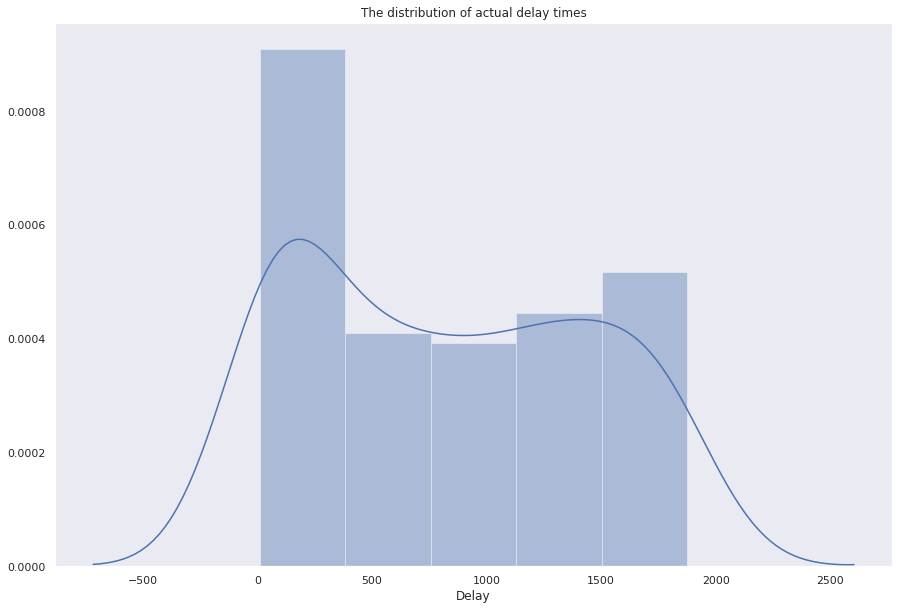

In [ ]:
sns.set(style="dark")
plt.figure(figsize=(15,10))
plt.title('The distribution of actual delay times')
sns.distplot(delaydistribution)

### Testing the **runSimulator** function varying the number of trains in an hour from 1 to 20 while keeping signalling blocks constant at 14.

In [ ]:
alldata = []
for i in range(1,21):
    sim = runSimulator(i,14)
    time = processDelay(sim)
    alldata.append((time))

Streaming output truncated to the last 5000 lines.
14:23:17 [Train  3] enters block 7 for journey to Birmingham Interchange
14:23:17 [Train  1] requests block 10 for journey to Birmingham Interchange
14:23:17 [Train  1] enters block 10 for journey to Birmingham Interchange
14:23:18 [Train 19] requests block 13 for journey to Birmingham Interchange
14:23:18 [Train 19] enters block 13 for journey to Birmingham Interchange
14:24:00 [Train  8] drives from train depot to starting station
14:24:15 [Train  8] Waiting to depart London Old Oak Commons for Birmingham Interchange
14:24:15 [Train  8] requests block 0 for journey to Birmingham Interchange
14:24:15 [Train  8] enters block 0 for journey to Birmingham Interchange
14:24:15 [Train  6] requests block 3 for journey to Birmingham Interchange
14:24:15 [Train  6] enters block 3 for journey to Birmingham Interchange
14:24:16 [Train  4] requests block 6 for journey to Birmingham Interchange
14:24:16 [Train  4] enters block 6 for journey to Bir

In [ ]:
alldata

[120.0,
 64.0,
 56.0,
 51.02,
 48.03,
 48.02,
 48.19,
 48.78,
 49.82,
 51.25,
 0.0,
 55.09,
 0.0,
 0.0,
 64.15,
 68.25,
 0.0,
 78.64,
 0.0,
 93.44]

In [ ]:
exp = pd.DataFrame(alldata, columns=['Time'])
exp

,Time
0,120.00
1,64.00
2,56.00
3,51.02
4,48.03
5,48.02
6,48.19
7,48.78
8,49.82
9,51.25


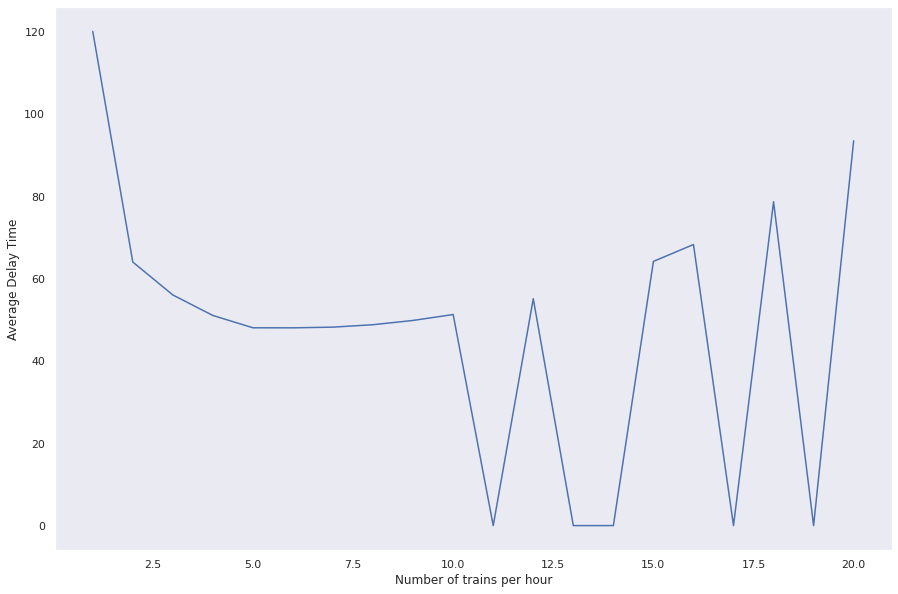

In [ ]:
sns.set(style="dark")
plt.figure(figsize=(15,10))
sns.lineplot(x=[x for x in range(1,21)], y=exp['Time'])
plt.xlabel('Number of trains per hour')
plt.ylabel('Average Delay Time')
plt.show()

The results of varying the number of trains with the signalling blocks at a constant 14 shown in the Line Plot above, it is seen that at 11, 13, 17 trains per hour the average delay time is minimal

### Testing **runSimulator** function varying the number of signalling blocks from 1 to 15 while keeping number of trains constant at 13.

In [ ]:
alldata_k = []
for i in range(1,16):
    sim = runSimulator(13,i)
    time = processDelay(sim)
    alldata_k.append((time))

Streaming output truncated to the last 5000 lines.
10:52:15 [Train  6] enters block 13 for journey to Birmingham Interchange
10:52:53 [Train 11] requests block 1 for journey to Birmingham Interchange
10:52:53 [Train 11] enters block 1 for journey to Birmingham Interchange
10:53:00 [Train  9] requests block 6 for journey to Birmingham Interchange
10:53:00 [Train  9] enters block 6 for journey to Birmingham Interchange
10:53:08 [Train  7] requests block 11 for journey to Birmingham Interchange
10:53:08 [Train  7] enters block 11 for journey to Birmingham Interchange
10:53:53 [Train 10] requests block 4 for journey to Birmingham Interchange
10:53:53 [Train 10] enters block 4 for journey to Birmingham Interchange
10:54:00 [Train  8] requests block 9 for journey to Birmingham Interchange
10:54:00 [Train  8] enters block 9 for journey to Birmingham Interchange
10:54:08 [Train  6] requests block 14 for journey to Birmingham Interchange
10:54:08 [Train  6] enters block 14 for journey to Birmin

In [ ]:
alldata_k

[136486.75,
 54812.75,
 27588.09,
 13975.75,
 5808.36,
 363.42,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
varyk = pd.DataFrame(alldata_k, columns=['Time'])
varyk

,Time
0,136486.75
1,54812.75
2,27588.09
3,13975.75
4,5808.36
5,363.42
6,0.00
7,0.00
8,0.00
9,0.00


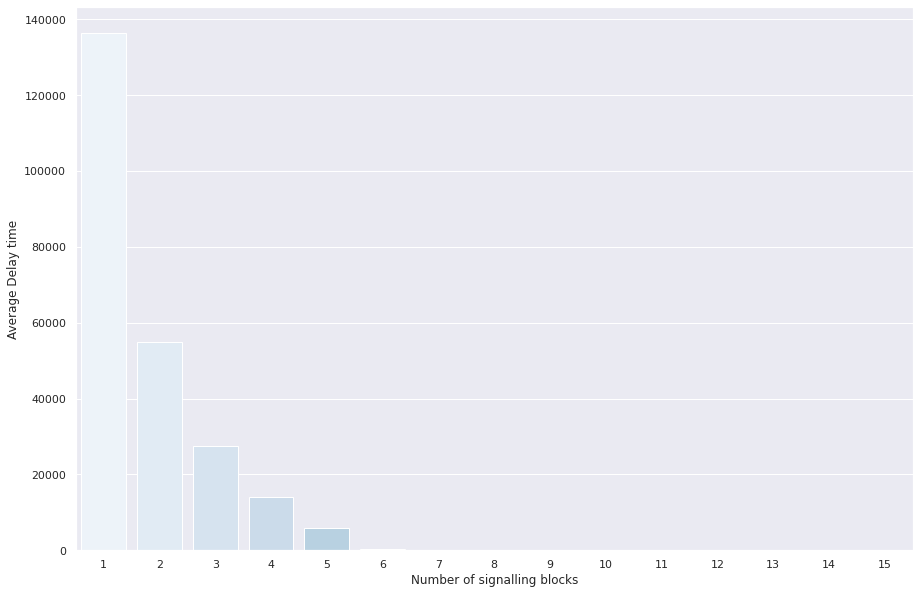

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,10))
sns.barplot(x=[x for x in range(1,16)], y=varyk['Time'],  palette="Blues")
plt.xlabel('Number of signalling blocks')
plt.ylabel('Average Delay time')
plt.show()

The results of varying the **signalling blocks (k)** shown above, It can be seen that at 13 trains per hour, the less signalling blocks, the more the average delay time. Five signalling blocks has the least average delay.

The next step is to better optimize this simulation by obtaining the optimum number of signalling blocks and number of trains per hour to maximise average delay.

# Optimization

Grid Search is used to maximise the number of trains operating per hour under the constraint that the average delay time should not be higher than half the scheduled time between consecutive trains.




### Grid Search

In [ ]:
n_trains = [i for i in range(1,31)]
k_signalBlocks = [x for x in range(1,21)]

grid_search = []

for i in n_trains:
    for j in k_signalBlocks:
        simulate_ex = runSimulator(i,j)
        time = processDelay(simulate_ex)
        if time < ((3600/i)/2):
           grid_search.append(((i,j),time))

Streaming output truncated to the last 5000 lines.
18:25:28 [Train  7] enters block 8 for journey to Birmingham Interchange
18:25:30 [Train  0] requests block 18 for journey to Birmingham Interchange
18:25:30 [Train  0] enters block 18 for journey to Birmingham Interchange
18:25:39 [Train 12] requests block 1 for journey to Birmingham Interchange
18:25:39 [Train 12] enters block 1 for journey to Birmingham Interchange
18:25:41 [Train  5] requests block 11 for journey to Birmingham Interchange
18:25:41 [Train  5] enters block 11 for journey to Birmingham Interchange
18:25:51 [Train 10] requests block 4 for journey to Birmingham Interchange
18:25:51 [Train 10] enters block 4 for journey to Birmingham Interchange
18:25:53 [Train  3] requests block 14 for journey to Birmingham Interchange
18:25:53 [Train  3] enters block 14 for journey to Birmingham Interchange
18:26:00 [Train 13] drives from train depot to starting station
18:26:04 [Train  8] requests block 7 for journey to Birmingham Int

In [ ]:
results = pd.DataFrame(grid_search, columns=['Train and Signalling Blocks','Delay'])
results

,Train and Signalling Blocks,Delay
0,"(1, 1)",120.0
1,"(1, 2)",120.0
2,"(1, 3)",120.0
3,"(1, 4)",120.0
4,"(1, 5)",120.0
...,...,...
330,"(28, 16)",0.0
331,"(28, 17)",0.0
332,"(28, 18)",0.0
333,"(28, 19)",0.0


In [ ]:
results[results['Delay'] == min(results['Delay'])]

,Train and Signalling Blocks,Delay
176,"(11, 6)",0.0
177,"(11, 7)",0.0
178,"(11, 8)",0.0
179,"(11, 9)",0.0
180,"(11, 10)",0.0
...,...,...
330,"(28, 16)",0.0
331,"(28, 17)",0.0
332,"(28, 18)",0.0
333,"(28, 19)",0.0


In [ ]:
from google.colab import files
results[results['Delay'] == min(results['Delay'])].to_csv('OptimizationResults.csv')
files.download('OptimizationResults.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The results using the grid search for the entire search space provides a dataframe with the number of trains and signalling blocks with the smallest delay times. 

Grid Search optimization is computationally expensive prodecure as it finds the optimal values by searching the entire spaces. 

## References

[1] S. Scherfke & O. Lünsdorf, [SimPy](https://simpy.readthedocs.io/en/latest/contents.html), Version 4.01. [Software].

[2] C. Horn, "London Underground Step 1," 2020. [Online]. Available: https://moodle.ncirl.ie/mod/resource/view.php?id=76704 

[3] C. Horn, "London Underground Step 2 v4," 2020. [Online]. Available: https://moodle.ncirl.ie/mod/resource/view.php?id=76707

[4] C. Horn, "London Underground Step 3 v4," 2020. [Online]. Available: https://moodle.ncirl.ie/mod/resource/view.php?id=76709

[5] C. Horn, "London Underground Step 4," 2020.  [Online]. Available: https://moodle.ncirl.ie/mod/resource/view.php?id=76960

[6] C. Horn, "London Underground Step 5," 2020.  [Online]. Available: https://moodle.ncirl.ie/mod/resource/view.php?id=76964

[7] C. Horn, "London Underground Step 6," 2020.  [Online]. Available: https://moodle.ncirl.ie/mod/resource/view.php?id=76968 

[8] Y. Yang, P. Huang, Q. Peng, L. Jie, and C. Wen, “Statistical delay
distribution analysis on high-speed railway trains,” Journal of Modern
Transportation, vol. 27, no. 3, pp. 188–197, 2019.

[9] “numpy.random.lognormal — numpy v1.19 manual,” https://numpy.org/doc/stable/reference/random/generated/numpy.random.lognormal.html, [Online] (Accessed on 08/06/2020).
